#  <font color='black'>Setting up</font>

##  <font color='blue'>Collapsible Headings</font>

Run the following commands in anaconda prompt to install a graphical interface for configuring collapsible headings and other extentions/plugins from within the notebooks:

pip install jupyter_contrib_nbextensions

jupyter contrib nbextension install --user

jupyter nbextensions_configurator enable --user

Once done, go to Jupyter notebook --> Nbextensions --> check the "Collapsible Headings" box

## <font color='blue'>Imports</font>

In [30]:
from tkinter import Tk
from tkinter import filedialog # for prompting user to set analysis folder
import glob
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

## <font color='blue'>Suppress Warnings</font>

In [81]:
import warnings
warnings.filterwarnings('ignore')

## <font color='blue'>Constants</font>

In [86]:
ABSORPTION_LIMIT = 5.0

# Convenience functions

## <font color='blue'>Construct file paths</font>

In [2]:
# construct file fullpath from folder_path and run_id

def construct_file_fullpath(folder_path, run_id):
    current_file_fullpath = ''
    files_fullpath = glob.glob(folder_path + '/*.fits')
    for f in files_fullpath:
        if run_id in f:
            current_file_fullpath = f                
    return current_file_fullpath

## <font color='blue'>Display image</font>

In [3]:
# function for safely handling subtractions...
# Credit: Eric A. Wolf, BEC1@MIT, 2022. 

def safe_subtract(x, y, minimum_cast = np.byte):
    newtype = np.result_type(x, y, minimum_cast)
    return x.astype(newtype) - y.astype(newtype)

In [93]:
# display an image given folder_path, run_id, ROI, and frame_type:
def display_image(current_file_fullpath, ROI, norm_box, 
                  frame_type = 'FakeOD', min_scale=0, max_scale=1.3, brightness=12):
    # set up figure
    fig, ax = plt.subplots()
    
    # read image
    fits_image = fits.open(current_file_fullpath)
    # fits_image.info() # display fits image info
    img = fits_image[0].data
    fits_image.close()

    # get dims of image
    dims = img[0,:,:].shape 
    x_limit = dims[1]
    y_limit = dims[0]

    # then show image:
    if frame_type == 'OD':
        frame = (-np.log(safe_subtract(img[0,:,:], img[2,:,:])/safe_subtract(img[1,:,:], img[2,:,:])))
        # clean image: using nan_to_num
        frame = np.nan_to_num(frame, nan=ABSORPTION_LIMIT)
        # fix clipping
        frame = np.clip(frame, 0, ABSORPTION_LIMIT)
        ax.imshow(frame, cmap='gray', vmin=0, vmax=2**15).set_clim(min_scale, max_scale)
        ax.invert_yaxis()

    else:
        if frame_type == 'FakeOD':
            frame = (safe_subtract(img[0,:,:], img[2,:,:])/safe_subtract(img[1,:,:], img[2,:,:]))
            # clean image: using nan_to_num
            frame = np.nan_to_num(frame)
            # fix clipping
            frame = np.clip(frame, 0, ABSORPTION_LIMIT)
            ax.imshow(frame, cmap='gray', vmin=0, vmax=2**15).set_clim(min_scale, max_scale)
            ax.invert_yaxis()
        else:
            if frame_type == 'With atoms':
                frame = img[0,:,:]
                # clean image: using nan_to_num
                frame = np.nan_to_num(frame)
                ax.imshow(frame, cmap='gray', vmin=0, vmax=2**brightness)  # need to adjust gray scale/colormap here with BRIGHTNESS variable
                ax.invert_yaxis()
            elif frame_type == 'Without atoms':
                frame = img[1,:,:]
                # clean image: using nan_to_num
                frame = np.nan_to_num(frame)
                ax.imshow(frame, cmap='gray', vmin=0, vmax=2**brightness)  # need to adjust gray scale/colormap here with BRIGHTNESS variable
                ax.invert_yaxis()
            elif frame_type == 'Dark':
                frame = img[2,:,:]
                # clean image: using nan_to_num
                frame = np.nan_to_num(frame)
                ax.imshow(frame, cmap='gray', vmin=0, vmax=2**brightness)  # need to adjust gray scale/colormap here with BRIGHTNESS variable
                ax.invert_yaxis()
            else:
                frame = (-np.log(safe_subtract(img[0,:,:], img[2,:,:])/safe_subtract(img[1,:,:], img[2,:,:])))
                # clean image: using nan_to_num
                frame = np.nan_to_num(frame)
                ax.imshow(frame, cmap='gray', vmin=0, vmax=2**15).set_clim(min_scale, max_scale)
                ax.invert_yaxis()
                
    # Create a roi patch
    width = abs(int(ROI[1]) - int(ROI[0]))
    height = abs(int(ROI[3]) - int(ROI[2]))
    xmin = min(int(ROI[0]), int(ROI[1]))
    ymin = min(int(ROI[2]), int(ROI[3]))
    roi = patches.Rectangle((xmin, ymin), 
                             width, 
                             height, 
                             linewidth=1, 
                             edgecolor='r', 
                             facecolor='none')
    # Add the ROI to the Axes
    ax.add_patch(roi)
    
    # Create a norm_box patch
    width_norm = abs(int(norm_box[1]) - int(norm_box[0]))
    height_norm = abs(int(norm_box[3]) - int(norm_box[2]))
    xmin_norm = min(int(norm_box[0]), int(norm_box[1]))
    ymin_norm = min(int(norm_box[2]), int(norm_box[3]))
    
    norm_roi = patches.Rectangle((xmin_norm, ymin_norm), 
                             width_norm, 
                             height_norm, 
                             linewidth=1, 
                             edgecolor='g', 
                             facecolor='none')
    # Add the ROI to the Axes
    ax.add_patch(roi)
    ax.add_patch(norm_roi)   
    # show everything
    plt.show()
                
    return (fig, ax)

## <font color='blue'>Pixel summing</font>

In [97]:
def get_pixel_sum_single_image(current_file_fullpath, ROI, norm_box):
    # read image
    fits_image = fits.open(current_file_fullpath)
    img = fits_image[0].data
    fits_image.close()

    # get od image, crop, and sum
    od = (-np.log(safe_subtract(img[0,:,:], img[2,:,:])/safe_subtract(img[1,:,:], img[2,:,:])))
    # now clean od:
    od = np.nan_to_num(od)
    # fix clipping
    od = np.clip(od, 0, ABSORPTION_LIMIT)
    od_cropped = od[ROI[0]:ROI[1], ROI[2]:ROI[3]] # just OD, but cropped
    return sum(sum(od_cropped))

In [99]:
def get_pixel_sum_folder(folder_path, ROI, norm_box):
    return 0

# Na Catch

# Na BEC

In [7]:
# select folder
folder_path = filedialog.askdirectory()

print('Current folder: ' + folder_path)

2023-02-09 11:04:43.817 python[17494:13605578] +[CATransaction synchronize] called within transaction
2023-02-09 11:04:43.825 python[17494:13605578] +[CATransaction synchronize] called within transaction
2023-02-09 11:04:43.844 python[17494:13605578] +[CATransaction synchronize] called within transaction
2023-02-09 11:04:43.865 python[17494:13605578] +[CATransaction synchronize] called within transaction
2023-02-09 11:04:43.880 python[17494:13605578] +[CATransaction synchronize] called within transaction
2023-02-09 11:04:43.912 python[17494:13605578] +[CATransaction synchronize] called within transaction
2023-02-09 11:04:46.747 python[17494:13605578] +[CATransaction synchronize] called within transaction


Current folder: /Users/huanbui/Desktop/sample_data/humongous BEC


In [8]:
# list all .fits files in the folder:
if folder_path:
    file_names = []
    files_fullpath = glob.glob(folder_path + '/*.fits')
    for f in files_fullpath:
        name = f.split(folder_path)
        file_names.append(str(name[1]).replace('\\',"")) # make list of file names
        
    for name in file_names: # print all file names
        print(str(file_names.index(name)) + ' ' + name)
else:
    print('No folder selected!')   

0 /unmatched_2022-08-19--13-53-20_Side.fits
1 /unmatched_2022-08-19--13-46-51_Side.fits
2 /unmatched_2022-08-19--13-57-52_Side.fits
3 /unmatched_2022-08-19--13-51-24_Side.fits
4 /unmatched_2022-08-19--13-48-09_Side.fits
5 /unmatched_2022-08-19--13-54-38_Side.fits
6 /unmatched_2022-08-19--13-59-48_Side.fits
7 /unmatched_2022-08-19--13-47-30_Side.fits
8 /unmatched_2022-08-19--13-48-48_Side.fits
9 /unmatched_2022-08-19--13-59-10_Side.fits
10 /unmatched_2022-08-19--13-55-17_Side.fits
11 /unmatched_2022-08-19--13-50-06_Side.fits
12 /unmatched_2022-08-19--13-58-31_Side.fits
13 /unmatched_2022-08-19--13-55-55_Side.fits
14 /unmatched_2022-08-19--13-50-44_Side.fits
15 /unmatched_2022-08-19--13-52-41_Side.fits
16 /unmatched_2022-08-19--13-53-59_Side.fits
17 /unmatched_2022-08-19--13-56-34_Side.fits
18 /unmatched_2022-08-19--13-52-02_Side.fits
19 /unmatched_2022-08-19--13-57-13_Side.fits
20 /unmatched_2022-08-19--13-49-27_Side.fits


In [ ]:
# load metadata:

# Li LF low magnification

In [74]:
# select folder
folder_path = filedialog.askdirectory()

print('Current folder: ' + folder_path)

2023-02-09 19:53:23.640 python[18641:13774467] +[CATransaction synchronize] called within transaction
2023-02-09 19:53:23.647 python[18641:13774467] +[CATransaction synchronize] called within transaction
2023-02-09 19:53:23.699 python[18641:13774467] +[CATransaction synchronize] called within transaction
2023-02-09 19:53:23.714 python[18641:13774467] +[CATransaction synchronize] called within transaction
2023-02-09 19:53:25.748 python[18641:13774467] +[CATransaction synchronize] called within transaction


Current folder: /Users/huanbui/Desktop/sample_data/li_odt_lf


In [83]:
# list all .fits files in the folder:
if folder_path:
    file_names = []
    files_fullpath = glob.glob(folder_path + '/*.fits')
    for f in files_fullpath:
        name = f.split(folder_path)
        file_names.append(str(name[1]).replace('\\',"")) # make list of file names
        
    for name in file_names: # print all file names
        print(str(file_names.index(name)) + ' ' + name)
else:
    print('No folder selected!')   

0 /1197421_2022-11-10--10-27-36_Side.fits
1 /1197424_2022-11-10--10-30-05_Side.fits
2 /1197420_2022-11-10--10-26-46_Side.fits
3 /1197425_2022-11-10--10-30-55_Side.fits
4 /1197423_2022-11-10--10-29-15_Side.fits
5 /1197419_2022-11-10--10-25-56_Side.fits
6 /1197422_2022-11-10--10-28-26_Side.fits


In [84]:
# load metadata file:
metadata_fullpath = folder_path + "/run_params_dump.json"
with open(metadata_fullpath, 'r') as json_file:
    metadata_dict = json.load(json_file)  

In [18]:
# print metadata for a certain run_id:
# print(metadata_dict['1197421'])

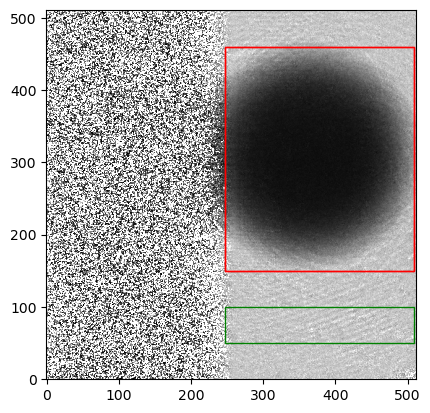

Displaying image: 
/Users/huanbui/Desktop/sample_data/li_odt_lf/1197421_2022-11-10--10-27-36_Side.fits

Frame type: FakeOD


In [108]:
# ROI Box and norm_box for MT LF
#...

# ROI Box and norm_box for ODT LF
# Li LF ROI Box (ODT):
Li_LF_X_min = 247
Li_LF_X_max = 509
Li_LF_Y_min = 150
Li_LF_Y_max = 460
ROI = [Li_LF_X_min, Li_LF_X_max, Li_LF_Y_min, Li_LF_Y_max]

# Li LF Norm Box (ODT):
Li_LF_X_min_norm = 247
Li_LF_X_max_norm = 509
Li_LF_Y_min_norm = 50
Li_LF_Y_max_norm = 100
norm_box = [Li_LF_X_min_norm, Li_LF_X_max_norm, Li_LF_Y_min_norm, Li_LF_Y_max_norm]

# display Li LF image given folder_path, run_id, ROI, and frame_type:
run_id = str(1197421)
frame_type = 'FakeOD'
current_file_fullpath = construct_file_fullpath(folder_path, run_id)

fig, ax = display_image(current_file_fullpath, ROI, norm_box, frame_type)

#################################################
print('Displaying image: ')
print(current_file_fullpath)
print('')
print('Frame type: ' + frame_type)

In [109]:
# get pixel sum in ROI for single od image:
print(current_file_fullpath)
print('')
print('Pixel sum from ROI:')
print(get_pixel_sum_single_image(current_file_fullpath, ROI, norm_box))

/Users/huanbui/Desktop/sample_data/li_odt_lf/1197421_2022-11-10--10-27-36_Side.fits

Pixel sum from ROI:
90352.80081670026


In [ ]:
# get pixel sum in ROI for entire folder:



# Li HF high magnification

# Li HF Top Absorption

# Li HF Top Polarization Rotation